In [4]:
#modelado de SCANVI basado en modelado anterior de SCVI
import os
import scanpy as sc
import anndata
import numpy as np
import scvi
import logging
import matplotlib.pyplot as plt

# Configurar el logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Cargar el archivo h5ad integrado
input_path = '/app/project/pipeline_colombia/4.models/scvi_model/scvi_integrated.h5ad'
logging.info(f"Cargando datos integrados desde: {input_path}")
adata = sc.read_h5ad(input_path)

# Cargar el modelo scVI previamente entrenado
scvi_model_path = '/app/project/pipeline_colombia/4.models/scvi_model'
logging.info(f"Cargando modelo scVI desde: {scvi_model_path}")
scvi_model = scvi.model.SCVI.load(scvi_model_path, adata)

# Determinar el valor para células no etiquetadas
unlabeled_category = "Uncategorized"  # Ajusta esto según tus datos

# Configurar anndata para scANVI
logging.info("Configurando anndata para scANVI")
scvi.model.SCANVI.setup_anndata(
    adata,
    layer="counts",
    batch_key='short_title',
    labels_key='cell_type',
    unlabeled_category=unlabeled_category,
    categorical_covariate_keys=['assay', 'self_reported_ethnicity', 'sex', 'donor_id']
)


# Crear y entrenar el modelo scANVI
logging.info("Creando y entrenando modelo scANVI")
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    scvi_model,
    adata=adata,
    labels_key='cell_type',
    unlabeled_category="Uncategorized"
)
scanvi_model.train(
    max_epochs=150,
    early_stopping=True,
    early_stopping_patience=15,
    )

# Guardar el modelo scANVI
scanvi_model_save_path = '/app/project/pipeline_colombia/4.models/scanvi_model'
logging.info(f"Guardando modelo scANVI en: {scanvi_model_save_path}")
scanvi_model.save(scanvi_model_save_path, overwrite=True)

# Obtener representaciones latentes
SCANVI_LATENT_KEY = "X_scANVI"
adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation()

# Calcular vecinos y UMAP
logging.info("Calculando vecinos y UMAP")
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

# Ejecutar clustering de Leiden
logging.info("Ejecutando clustering de Leiden")
sc.tl.leiden(adata, key_added="scanvi_leiden")

# Crear directorio para guardar figuras si no existe
figures_dir = '/app/project/pipeline_colombia/4.models/scanvi_model'
os.makedirs(figures_dir, exist_ok=True)

# Visualizar y guardar UMAP por muestra
logging.info("Generando y guardando UMAP por muestra")
fig, ax = plt.subplots(figsize=(10, 8))
sc.pl.umap(adata, color="short_title", ax=ax, show=False)
plt.title("scANVI UMAP por muestra")
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'scanvi_umap_sample.png'))
plt.close()

# Visualizar y guardar UMAP por tipo de célula
logging.info("Generando y guardando UMAP por tipo de célula")
fig, ax = plt.subplots(figsize=(10, 8))
sc.pl.umap(adata, color="cell_type", ax=ax, show=False)
plt.title("scANVI UMAP por tipo de célula")
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'scanvi_umap_cell_type.png'))
plt.close()

# Visualizar y guardar UMAP por clustering de Leiden
logging.info("Generando y guardando UMAP por clustering de Leiden")
fig, ax = plt.subplots(figsize=(10, 8))
sc.pl.umap(adata, color="scanvi_leiden", ax=ax, show=False)
plt.title("scANVI UMAP por clustering de Leiden")
plt.tight_layout()
plt.savefig(os.path.join(figures_dir, 'scanvi_umap_leiden.png'))
plt.close()

# Guardar el objeto AnnData actualizado
output_path = '/app/project/pipeline_colombia/4.models/scanvi_model/scanvi_integrated.h5ad'
logging.info(f"Guardando objeto AnnData actualizado en: {output_path}")
adata.write(output_path)

logging.info("Proceso completado con éxito")

2024-10-26 19:13:58,731 - INFO - Cargando datos integrados desde: /app/project/pipeline_colombia/4.models/scvi_model/scvi_integrated.h5ad
2024-10-26 19:14:01,035 - INFO - Cargando modelo scVI desde: /app/project/pipeline_colombia/4.models/scvi_model


INFO     File /app/project/pipeline_colombia/4.models/scvi_model/model.pt already downloaded                       


/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/scvi/model/base/_utils.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_locati

INFO     Training for 150 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 16/150:  11%|█         | 16/150 [00:41<05:51,  2.62s/it, v_num=1, train_loss_step=640, train_loss_epoch=657]

2024-10-26 19:14:43,643 - INFO - Guardando modelo scANVI en: /app/project/pipeline_colombia/4.models/scanvi_model



Monitored metric elbo_validation did not improve in the last 15 records. Best score: 722.399. Signaling Trainer to stop.


2024-10-26 19:14:44,005 - INFO - Calculando vecinos y UMAP
2024-10-26 19:14:51,287 - INFO - Ejecutando clustering de Leiden
/tmp/ipykernel_97868/3642434488.py:68: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added="scanvi_leiden")
2024-10-26 19:15:02,015 - INFO - Generando y guardando UMAP por muestra
2024-10-26 19:15:02,274 - INFO - Generando y guardando UMAP por tipo de célula
2024-10-26 19:15:02,481 - INFO - Generando y guardando UMAP por clustering de Leiden
2024-10-26 19:15:02,829 - INFO - Guardando objeto AnnData actualizado en: /app/project/pipeline_colombia/4.models/scanvi_model/scanvi_integrated.h5ad
2024-10-26 19:15:05,384 - INFO - Proceso completado con éxito


In [2]:
adata

AnnData object with n_obs × n_vars = 12225 × 5000
    obs: 'donor_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'cell_group', 'años', 'grupos_edades', 'source_file', 'title', 'short_title', 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'sample', 'compose_batch_key', '_scvi_batch', '_scvi_labels', 'leiden', 'scanvi_leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'genome', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'modality', 'neighbors', 'pca', 'short_title_colors', 'source_file_colors', 'uid', 'umap', 'scanvi_leiden', 'scanvi_leiden_colors'
    obsm: 'X_pca', 'X_s

2024-10-26 19:32:03,413 - INFO - Cargando datos integrados desde: /app/project/pipeline_colombia/4.models/scanvi_model/scanvi_integrated.h5ad
2024-10-26 19:32:05,663 - INFO - Configurando el objeto Benchmarker
2024-10-26 19:32:05,665 - INFO - Ejecutando métricas de benchmarking
Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     cd16-positive, cd56-dim natural killer cell, human consists of a single batch or is too small. Skip.      


/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  33%|███▎      | 1/3 [00:14<00:29, 14.98s/it]/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     cd16-positive, cd56-dim natural killer cell, human consists of a single batch or is too small. Skip.      


/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  67%|██████▋   | 2/3 [00:27<00:13, 13.60s/it]/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     cd16-positive, cd56-dim natural killer cell, human consists of a single batch or is too small. Skip.      


/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings: 100%|██████████| 3/3 [00:38<00:00, 12.73s/it]
2024-10-26 19:32:53,741 - INFO - Generando visualizaciones de los resultados
/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/scib_metrics/benchmark/_core.py:268: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Aggregate score' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[_METRIC_TYPE, per_class_score.columns] = _AGGREGATE_SCORE
/root/.pyenv/versions/3.9.7/lib/python3.9/site-packages/scib_metrics/benchmark/_core.py:268: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pan

<Figure size 1200x800 with 0 Axes>

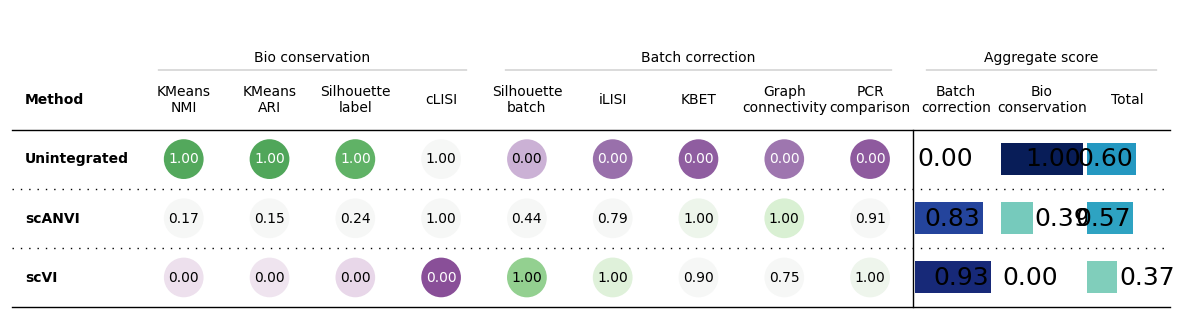

2024-10-26 19:32:54,039 - INFO - Imprimiendo resultados:
2024-10-26 19:32:54,042 - INFO - Evaluación de métricas de integración completada
2024-10-26 19:32:54,044 - INFO - Generando visualizaciones UMAP


                    KMeans NMI        KMeans ARI  Silhouette label  \
Embedding                                                            
Unintegrated          0.465043          0.288535          0.624221   
scVI                  0.038052          0.018007          0.459977   
scANVI                0.112565           0.05753          0.499779   
Metric Type   Bio conservation  Bio conservation  Bio conservation   

                         cLISI  Silhouette batch             iLISI  \
Embedding                                                            
Unintegrated               1.0          0.857237          0.005082   
scVI                  0.910502          0.903978          0.402645   
scANVI                     1.0          0.877704          0.317256   
Metric Type   Bio conservation  Batch correction  Batch correction   

                          KBET Graph connectivity    PCR comparison  \
Embedding                                                             
Unintegrated    

2024-10-26 19:32:54,413 - INFO - Número total de células: 12206
2024-10-26 19:32:54,414 - INFO - Número de genes: 2000
2024-10-26 19:32:54,415 - INFO - Número de batches: 5
2024-10-26 19:32:54,416 - INFO - Tipos celulares: ['natural killer cell', 'cd16-negative, cd56-bright natural killer cel..., 'cd16-positive, cd56-dim natural killer cell, ...]
Categories (3, object): ['cd16-negative, cd56-bright natural killer cel..., 'cd16-positive, cd56-dim natural killer cell, ..., 'natural killer cell']


Tabla de resultados escalados


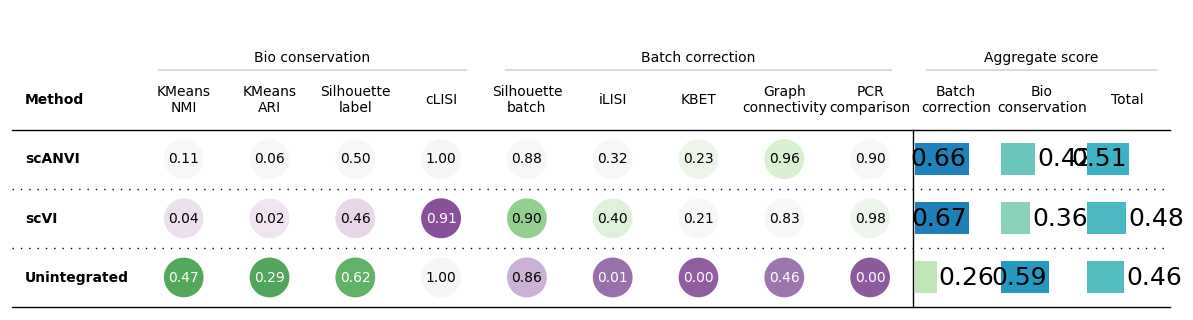

In [5]:
#Benchmarking de los métodos
import scanpy as sc
import scib
from scib_metrics.benchmark import Benchmarker, BioConservation
import numpy as np
import matplotlib.pyplot as plt
import logging


####################################  
'''

import faiss

from scib_metrics.nearest_neighbors import NeighborsResults


def faiss_hnsw_nn(X: np.ndarray, k: int):
    """Gpu HNSW nearest neighbor search using faiss.

    See https://github.com/nmslib/hnswlib/blob/master/ALGO_PARAMS.md
    for index param details.
    """
    X = np.ascontiguousarray(X, dtype=np.float32)
    res = faiss.StandardGpuResources()
    M = 32
    index = faiss.IndexHNSWFlat(X.shape[1], M, faiss.METRIC_L2)
    gpu_index = faiss.index_cpu_to_gpu(res, 0, index)
    gpu_index.add(X)
    distances, indices = gpu_index.search(X, k)
    del index
    del gpu_index
    # distances are squared
    return NeighborsResults(indices=indices, distances=np.sqrt(distances))


def faiss_brute_force_nn(X: np.ndarray, k: int):
    """Gpu brute force nearest neighbor search using faiss."""
    X = np.ascontiguousarray(X, dtype=np.float32)
    res = faiss.StandardGpuResources()
    index = faiss.IndexFlatL2(X.shape[1])
    gpu_index = faiss.index_cpu_to_gpu(res, 0, index)
    gpu_index.add(X)
    distances, indices = gpu_index.search(X, k)
    del index
    del gpu_index
    # distances are squared
    return NeighborsResults(indices=indices, distances=np.sqrt(distances))

###################################    
'''

# Configurar logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Cargar los datos integrados
input_path = '/app/project/pipeline_colombia/4.models/scanvi_model/scanvi_integrated.h5ad'
logging.info(f"Cargando datos integrados desde: {input_path}")
adata = sc.read_h5ad(input_path)

# Asegurarse de que tenemos las representaciones no integradas
if "X_pca" not in adata.obsm:
    logging.info("Calculando PCA para datos no integrados")
    sc.pp.pca(adata)
adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

#scVI

adata.obsm["scVI"] = adata.obsm["X_scVI"]

#scANVI

adata.obsm["scANVI"] = adata.obsm["X_scANVI"]


# Configurar el objeto Benchmarker
logging.info("Configurando el objeto Benchmarker")
biocons = BioConservation(isolated_labels=False)
bm = Benchmarker(
    adata,
    batch_key= "short_title",
    label_key="cell_type",
    embedding_obsm_keys=["Unintegrated", "scVI", "scANVI"],
    pre_integrated_embedding_obsm_key="X_pca",
    bio_conservation_metrics=biocons,
    n_jobs=3,
)


# Ejecutar las métricas de benchmarking
logging.info("Ejecutando métricas de benchmarking")
bm.prepare()  #neighbor_computer=faiss_brute_force_nn
bm.benchmark()

# Visualizar los resultados
logging.info("Generando visualizaciones de los resultados")
plt.figure(figsize=(12, 8))
bm.plot_results_table()
plt.tight_layout()
plt.savefig('/app/project/pipeline_colombia/4.models/scanvi_model/integration_metrics.png')
plt.close()

# Obtener y guardar los resultados como CSV
results_df = bm.get_results(min_max_scale=False)
results_df.to_csv('/app/project/pipeline_colombia/4.models/scanvi_model/integration_metrics_results.csv')

logging.info("Imprimiendo resultados:")
print(results_df)
logging.info("Evaluación de métricas de integración completada")

# Visualizaciones adicionales
# UMAP por batch y tipo celular
logging.info("Generando visualizaciones UMAP")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sc.pl.umap(adata, color="short_title", ax=ax1, show=False, title="UMAP por batch")
sc.pl.umap(adata, color="cell_type", ax=ax2, show=False, title="UMAP por tipo celular")
plt.tight_layout()
plt.savefig('/app/project/pipeline_colombia/4.models/scanvi_model/umap_visualization.png')
plt.close()

# Información adicional del dataset
logging.info(f"Número total de células: {adata.n_obs}")
logging.info(f"Número de genes: {adata.n_vars}")
logging.info(f"Número de batches: {adata.obs['short_title'].nunique()}")
logging.info(f"Tipos celulares: {adata.obs['cell_type'].unique()}")


print('Tabla de resultados escalados')
bm.plot_results_table(min_max_scale=False)